## HDBSCAN with DBSCAN example code and then HDBSCAN with a correlation matrix

### HDBSCAN using the DBSCAN example code

see the 'Clustering algorithms' section of [Avoiding common pitfalls when clustering biological data](https://stke.sciencemag.org/content/9/432/re6) for background about DBSCAN algorithm and how it is a density-based algorithm. According to [here](https://hdbscan.readthedocs.io/en/latest/how_to_use_epsilon.html), "HDBSCAN* is basically a DBSCAN implementation for varying epsilon values and therefore only needs the minimum cluster size as single input parameter.". [Here](https://github.com/scikit-learn-contrib/hdbscan) illustrates simple use of HDBSCAN.

Estimated number of clusters: 3
Estimated number of noise points: 46
Homogeneity: 0.917
Completeness: 0.799
V-measure: 0.854
Adjusted Rand Index: 0.894
Adjusted Mutual Information: 0.853
Silhouette Coefficient: 0.593


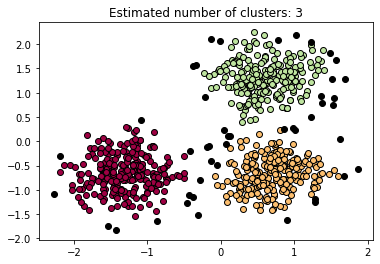

In [1]:
import numpy as np

import hdbscan
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = hdbscan.HDBSCAN(min_cluster_size=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
# `labels_true` in next few lines are the cluster labels defined `make_blobs()` 
# that generated the mock data and so is being used to compare expected with 
# result from DBSCAN calling cluster membership.
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Note if you look at the result with DBSCAN directly illustrated in my notebook [dbscan](dbscan.ipynb), you'll see HDBSCAN increases what is identified as noise. Since these blobs were defined as mock data, this seems worse that DBSCAN directly. However, real data is more often noisy and HDBSCAN is meant to be " a fast and robust algorithm that you can trust to return meaningful clusters (if there are any)." [Source](https://github.com/scikit-learn-contrib/hdbscan).

------

### HDBSCAN with a correlation matrix

Combining the use of DBSCAN with a correlation matrix as a dataframe and https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html

Builds a lot on my notebook [dbscan](dbscan.ipynb) which built a lot on my notebook [Hierarchical_clustering.ipynb](Hierarchical_clustering.ipynb).

-----

First make a dataframe that has 3 clusters. Based on https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb , see my notebook [Hierarchical_clustering.ipynb](Hierarchical_clustering.ipynb).

In [2]:
import pandas as pd
import numpy as np

# Generate 50 variables with 1000 samples
n_variables = 50
n_samples = 1000

# Those variables will be spread over 3 clusters of variable sizes
cluster_size = [5,22,28]
n_clusters = len(cluster_size)

# Assign each variable to a cluster
belongs_to_cluster = [i for i, c in enumerate(cluster_size) for n in range(c)]
np.random.shuffle(belongs_to_cluster)

# This latent data is used to make variables that belong
# to the same cluster correlated.
latent = np.random.randn(n_clusters, n_samples)

variables = []
for i in range(n_variables):
    variables.append(np.random.randn(n_samples) + latent[belongs_to_cluster[i], :])

df = pd.DataFrame(np.array(variables).transpose())

In [3]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.502998,-0.708941,0.313685,-0.209962,2.506514,-1.943229,0.546695,0.118956,0.320020,-0.023224,...,-0.044039,-0.843753,0.558107,0.357188,0.418433,1.437409,0.619454,-2.264086,1.269974,0.200331
1,0.803445,0.415901,-0.021587,-0.824499,1.494333,1.304870,-1.575719,1.398341,-0.488034,-0.534030,...,1.147997,0.595869,-0.354277,-0.304123,0.423553,0.260904,0.624385,-0.451143,-1.770494,-0.348787
2,-0.197374,-0.021411,-0.190851,-0.034545,-0.647693,-0.842942,-1.448753,-1.455168,0.144096,-1.695525,...,-1.670837,-2.548610,-0.543283,0.096898,-1.606158,-1.828930,0.948001,-0.870026,-1.853608,-5.273704
3,-1.318426,-1.558433,1.725419,3.201767,-0.540151,-2.059623,2.565826,-2.512119,-0.846871,3.088739,...,-1.881078,-0.513286,2.163948,-0.090089,2.165515,-1.142164,1.894209,-0.436227,0.893819,2.682222
4,1.977107,1.480991,2.513647,-0.228902,1.608810,0.530540,-0.955543,1.865037,1.658074,-0.609645,...,2.282608,2.455550,0.414766,1.848940,-0.277194,1.559071,0.730505,1.096558,1.316724,-1.180428
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.818596,-0.162028,2.593004,0.252105,-0.043264,-1.669463,2.333378,-0.086463,0.923031,1.514420,...,-0.122506,0.147340,1.159166,1.308651,1.140259,-1.533173,1.124984,0.233743,-0.752294,0.560267
996,2.833429,4.036991,0.571584,0.733272,3.299365,-0.075421,0.005938,1.954951,3.087349,-0.337231,...,0.567809,0.537786,1.841011,4.728796,-0.139396,1.811474,0.247011,1.032079,-0.020546,-0.659338
997,1.687171,-0.070124,0.380842,-1.730550,1.115412,0.569142,-1.599200,0.443664,-0.818328,-0.656391,...,-0.924660,-0.380377,-0.741015,-0.428064,-0.800063,1.446706,-2.282685,2.195032,-0.718591,-0.840117
998,0.051561,-1.996567,-3.193714,-2.727236,0.328831,0.313819,-0.639170,-0.560742,-3.033174,-2.932677,...,-0.992331,0.538274,-2.014811,-0.890591,-1.668823,-1.460275,-3.063672,-0.808152,-1.555896,-2.711063


So DBSCAN takes distance matrix. And so does HDBSCAN. 

Setting `min_samples` to 4 since small grouping in mock data used as input was five.

In [4]:
import scipy
import scipy.cluster.hierarchy as sch
import hdbscan
from sklearn import metrics

dfX = df.corr().values
X = metrics.pairwise_distances(dfX) 

db = hdbscan.HDBSCAN(min_cluster_size=4).fit(X) #see discussion where `min_samples` should have been 4!
labels = db.labels_
#print(labels)  #FOR DEBUGGING

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

labels_true = False
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

for x in np.unique(labels):
    class_members = [xc for xc in labels if xc == x]
    print(f"{len(class_members)} variables in grouping {x}")

Estimated number of clusters: 3
Estimated number of noise points: 0
25 variables in grouping 0
20 variables in grouping 1
5 variables in grouping 2


Now how do I plot the result though???  
The trick to going to the heatmap plot is to realize that for DBSCAN (and HDBSCAN), the labels (specifically `db.labels_`) are like the `ind` index from the correlation matrix clustering example.

In [5]:
import seaborn as sns
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot
        
    based on https://github.com/TheLoneNut/CorrelationMatrixClustering/blob/master/CorrelationMatrixClustering.ipynb
    and converted to using Seaborn 
    and adding plotting only lower triangular of the matrix
    by Wayne 6-10-2020
    '''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr_df = df.corr()
    
    # make the mask based on https://cmdlinetips.com/2020/02/lower-triangle-correlation-heatmap-python/
    mask_ut=np.triu(np.ones(corr_df.shape)).astype(bool)
    #print( mask_ut)  # FOR DEBUGGING
    
    # Plot the correlation matrix
    '''
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='RdYlGn')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)
    '''
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size+2, size))
    sns.heatmap(corr_df, mask=mask_ut, cmap="RdYlGn")

The above cell defines the plotting function. And now to plot:

Estimated number of clusters: 3
Estimated number of noise points: 0
25 variables in grouping 0
20 variables in grouping 1
5 variables in grouping 2


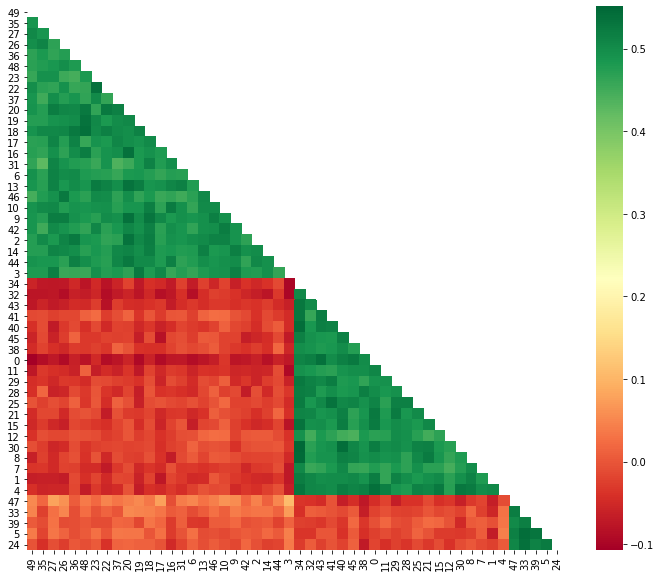

In [6]:
import scipy
import scipy.cluster.hierarchy as sch
from sklearn.cluster import DBSCAN
from sklearn import metrics


dfX = df.corr().values
X = metrics.pairwise_distances(dfX) 


db = hdbscan.HDBSCAN(min_cluster_size=4).fit(X) #see discussion where `min_samples` should have been 4!
labels = db.labels_
#print(labels)  #FOR DEBUGGING

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

labels_true = False
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
for x in np.unique(labels):
    class_members = [xc for xc in labels if xc == x]
    print(f"{len(class_members)} variables in grouping {x}")

columns = [df.columns.tolist()[i] for i in list((np.argsort(labels)))]
df_clustered = df.reindex(columns, axis=1) # this line updated from source because `df.reindex_axis()` deprecated
plot_corr(df_clustered, size=10)

To compare to **hierarchical clustering result below** (worked out in [Hierarchical_clustering.ipynb](Hierarchical_clustering.ipynb)):

number of clusters determined: 3
20 variables in cluster 1
5 variables in cluster 2
25 variables in cluster 3
Cluster breakdown:
The 20 members of cluster 1 are: [0, 1, 4, 7, 8, 11, 12, 15, 21, 25, 28, 29, 30, 32, 34, 38, 40, 41, 43, 45]
The SORTED 20 members of cluster 1 are: [0, 1, 4, 7, 8, 11, 12, 15, 21, 25, 28, 29, 30, 32, 34, 38, 40, 41, 43, 45]
The 25 members of cluster 0 are: [2, 3, 6, 9, 10, 13, 14, 16, 17, 18, 19, 20, 22, 23, 26, 27, 31, 35, 36, 37, 42, 44, 46, 48, 49]
The SORTED 25 members of cluster 0 are: [2, 3, 6, 9, 10, 13, 14, 16, 17, 18, 19, 20, 22, 23, 26, 27, 31, 35, 36, 37, 42, 44, 46, 48, 49]
The 5 members of cluster 2 are: [5, 24, 33, 39, 47]
The SORTED 5 members of cluster 2 are: [5, 24, 33, 39, 47]


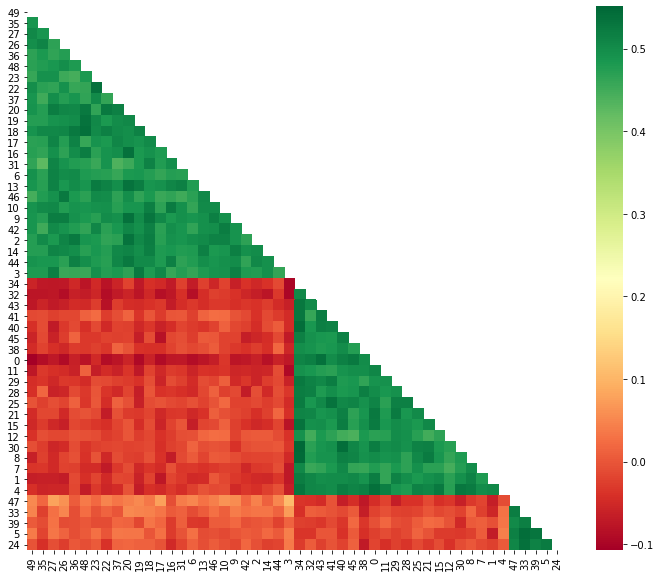

In [7]:
# hierarchical clustering  <--- FOR comparing to DBSCAN result
import scipy
import scipy.cluster.hierarchy as sch


X = df.corr().values
d = sch.distance.pdist(X)   # vector of ('55' choose 2) pairwise distances
L = sch.linkage(d, method='complete')
ind = sch.fcluster(L, 0.5*d.max(), 'distance')
columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
df_clustered = df.reindex(columns, axis=1) # this line updated from source because `df.reindex_axis()` deprecated

print("number of clusters determined:",len(np.unique(ind)))
for x in np.unique(ind):
    class_members = [xc for xc in ind if xc == x]
    print(f"{len(class_members)} variables in cluster {x}")

# Membership report-lite (based on code first worked out under 
# 'Obtaining and viewing the cluster membership without the rest of plot' section of 
# my notebook `Correlation matrix clustering featuring heatmap plot with seaborn.ipynb`.)
clusterBYindex = zip(labels.tolist(),df.columns)
from collections import defaultdict 
cluster_assignments = defaultdict(list)
for x in clusterBYindex:
    cluster_assignments[x[0]].append(x[1])
print("Cluster breakdown:")
for k,v in cluster_assignments.items():
    print(f"The {len(v)} members of cluster {k} are: {v}")
    print(f"The SORTED {len(v)} members of cluster {k} are: {sorted(v)}")

columns = [df.columns.tolist()[i] for i in list((np.argsort(labels)))]
df_clustered_hc = df.reindex(columns, axis=1) # this line updated from source because `df.reindex_axis()` deprecated
plot_corr(df_clustered_hc, size=10)

The smallest cluster is the easiest to compare since the indices are so few the members are't overly confusing to compare. HDBSCAN clearly calls this grouping with members the same as the hierarchical clustering results.  
Many of the other members are the same in the larger groups as can be seen in the text report.   
A visualization (worked out in my notebook [Hierarchical_clustering.ipynb](Hierarchical_clustering.ipynb)) to illustrate that is shown in the next cell.

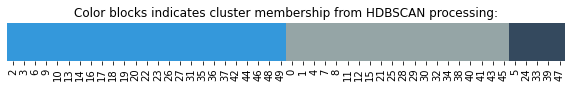

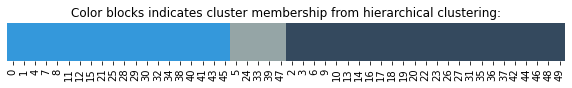

In [8]:
# Visualize members for each
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data for HDBSCAN
data4df = labels
df4view = pd.DataFrame(data4df)  #<--- note DO NOT USE `pd.DataFrame.from_records` here
df4view = df4view.T
labels4df = sorted(list(df_clustered.columns))
df4view.columns = labels4df
df4viewreoriented = df4view.T
df4viewreoriented = df4viewreoriented.rename_axis('sample_ids')
df4viewreoriented.columns = ["cluster_num"]
df4viewreoriented = df4viewreoriented.sort_values(by = ['cluster_num', 'sample_ids'], ascending = [True, True])
df4view = df4viewreoriented.T

# Plot after data preparation
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"] # from https://seaborn.pydata.org/tutorial/color_palettes.html
flatui = [ "#3498db", "#9b59b6", "#95a5a6", "#2ecc71","#34495e"] # based on https://seaborn.pydata.org/tutorial/color_palettes.html
plt.figure(figsize=(10, 0.7)) #from https://stackoverflow.com/a/55173418/8508004
g = sns.heatmap(df4view, cmap=flatui,cbar=False) # hiding colorbar based 
# on https://stackoverflow.com/q/50454360/8508004

g.set_yticklabels([""]) 
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
)
g.set_xlabel("") # when added column name to make the sorting work I had to then turn off;
# used approach like mentioned above for determining `g.set_yticklabels([""])` above

plt.title("Color blocks indicates cluster membership from HDBSCAN processing:");

# Prepare the data for hierarchichal clustering
data4df = ind
df4view = pd.DataFrame(data4df)  #<--- note DO NOT USE `pd.DataFrame.from_records` here
df4view = df4view.T
labels4df = sorted(list(df_clustered_hc.columns))
df4view.columns = labels4df
df4viewreoriented = df4view.T
df4viewreoriented = df4viewreoriented.rename_axis('sample_ids')
df4viewreoriented.columns = ["cluster_num"]
df4viewreoriented = df4viewreoriented.sort_values(by = ['cluster_num', 'sample_ids'], ascending = [True, True])
df4view = df4viewreoriented.T

# Plot after data preparation
plt.figure(figsize=(10, 0.7)) #from https://stackoverflow.com/a/55173418/8508004
g = sns.heatmap(df4view, cmap=flatui,cbar=False) # hiding colorbar based 
# on https://stackoverflow.com/q/50454360/8508004

g.set_yticklabels([""])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the left edge are off
)
g.set_xlabel("")
plt.title("Color blocks indicates cluster membership from hierarchical clustering:");

Although the label of the clusters are different and so the exact order of the different clusters is different betwen the two plots, the groupings are clearly the same.

----

----